In [3]:

import pandas as pd
import numpy as np
import joblib
import lightgbm as lgb
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import warnings
import os
import gc
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Configuration


# File paths
DRIVE_PATH = '/content/drive/MyDrive/DRW Crypto Market Prediction/'
MODEL_PATH = DRIVE_PATH + 'final_model.pkl'
SELECTED_FEATURES_PATH = DRIVE_PATH + 'selected_features.csv'

# Competition data paths (MOVED TO DRIVE)
TEST_PATH = DRIVE_PATH + 'test_with_features.parquet'
SAMPLE_SUBMISSION_PATH = DRIVE_PATH + 'sample_submission.csv'

# Output paths
SUBMISSION_PATH = DRIVE_PATH + 'final_submission.csv'

print("Configuration loaded - all files from Drive")
print(f"Test data path: {TEST_PATH}")
print(f"Sample submission path: {SAMPLE_SUBMISSION_PATH}")



Configuration loaded - all files from Drive
Test data path: /content/drive/MyDrive/DRW Crypto Market Prediction/test_with_features.parquet
Sample submission path: /content/drive/MyDrive/DRW Crypto Market Prediction/sample_submission.csv


In [5]:

# Load and check what's in the model file
model_data = joblib.load(MODEL_PATH)
print(f"Model file contains: {type(model_data)}")

if isinstance(model_data, dict):
    print("Model file is a dictionary with keys:", list(model_data.keys()))
    # Try to find the actual model in the dict
    if 'model' in model_data:
        final_model = model_data['model']
    elif 'final_model' in model_data:
        final_model = model_data['final_model']
    else:
        # Look for LightGBM model in values
        for key, value in model_data.items():
            if hasattr(value, 'predict'):
                final_model = value
                print(f"Found model in key: {key}")
                break
        else:
            print("ERROR: No model found in the dictionary")
            raise ValueError("No valid model found")
else:
    final_model = model_data

print(f"Final model type: {type(final_model)}")

# Load selected features (handle different formats)
features_df = pd.read_csv(SELECTED_FEATURES_PATH)
print(f"Features file columns: {features_df.columns.tolist()}")
print(f"Features file shape: {features_df.shape}")

# Try different column names
if 'features' in features_df.columns:
    selected_features = features_df['features'].tolist()
elif 'feature' in features_df.columns:
    selected_features = features_df['feature'].tolist()
elif len(features_df.columns) == 1:
    # Single column, use it regardless of name
    selected_features = features_df.iloc[:, 0].tolist()
else:
    # If it's a list without header, use the first column
    selected_features = features_df.iloc[:, 0].tolist()

print(f"Loaded {len(selected_features)} features")
print(f"First 5 features: {selected_features[:5]}")

Model file contains: <class 'dict'>
Model file is a dictionary with keys: ['model', 'best_params', 'best_score', 'timestamp']
Final model type: <class 'lightgbm.sklearn.LGBMRegressor'>
Features file columns: ['feature']
Features file shape: (400, 1)
Loaded 400 features
First 5 features: ['X286', 'X89', 'X97', 'X738', 'X564']


In [6]:

# Load test data
test_data = pd.read_parquet(TEST_PATH)
print(f"Test data shape: {test_data.shape}")

# Load sample submission
sample_submission = pd.read_csv(SAMPLE_SUBMISSION_PATH)
print(f"Sample submission shape: {sample_submission.shape}")
print("Sample format:")
print(sample_submission.head(3))

Test data shape: (538150, 882)
Sample submission shape: (538150, 2)
Sample format:
   ID  prediction
0   1   -0.280233
1   2    1.371969
2   3   -2.045252


In [7]:
# Prepare Test Features

common_features = set(selected_features) & set(test_data.columns)
missing_features = set(selected_features) - set(test_data.columns)

print(f"Available features: {len(common_features)}/{len(selected_features)}")
if missing_features:
    print(f"Missing {len(missing_features)} features - using available subset")
    available_features = [f for f in selected_features if f in test_data.columns]
else:
    available_features = selected_features

# Create test matrix
X_test = test_data[available_features].copy()
print(f"Test matrix: {X_test.shape}")

# Handle missing values
if X_test.isnull().sum().sum() > 0:
    print("Filling missing values with median")
    X_test.fillna(X_test.median(), inplace=True)

# Handle infinite values
if np.isinf(X_test).sum().sum() > 0:
    print("Replacing infinite values")
    X_test.replace([np.inf, -np.inf], np.nan, inplace=True)
    X_test.fillna(X_test.median(), inplace=True)

print("Test data preprocessed")

Available features: 197/400
Missing 203 features - using available subset
Test matrix: (538150, 197)
Filling missing values with median
Test data preprocessed


In [9]:
# CELL 6: Generate Predictions (Retrain on available features)
print("Model expects 400 features but test has 197. Retraining on available features...")

# Get available features
available_features = [f for f in selected_features if f in X_test.columns]
print(f"Retraining on {len(available_features)} available features")

# Load training data
train_final = pd.read_parquet(DRIVE_PATH + 'train_final_selected.parquet')
X_train_subset = train_final[available_features]
y_train = train_final['label']

# Retrain with best parameters
best_params = {
    'bagging_fraction': 0.8, 'bagging_freq': 5, 'boosting_type': 'gbdt',
    'feature_fraction': 0.9, 'learning_rate': 0.1, 'metric': 'rmse',
    'n_estimators': 2000, 'num_leaves': 200, 'objective': 'regression',
    'random_state': 42, 'verbose': -1
}

import lightgbm as lgb
retrained_model = lgb.LGBMRegressor(**best_params)
retrained_model.fit(X_train_subset, y_train)
print("Model retrained successfully")

# Make predictions
predictions = retrained_model.predict(X_test)
print(f"Generated {len(predictions)} predictions")

# Basic stats
pred_stats = pd.Series(predictions).describe()
print(f"Mean: {pred_stats['mean']:.4f}, Std: {pred_stats['std']:.4f}")
print(f"Range: [{pred_stats['min']:.4f}, {pred_stats['max']:.4f}]")

# Fix any problematic values
if np.isnan(predictions).sum() > 0:
    predictions = np.nan_to_num(predictions, nan=0.0)
    print("Fixed NaN predictions")

if np.isinf(predictions).sum() > 0:
    predictions = np.nan_to_num(predictions, posinf=1.0, neginf=-1.0)
    print("Fixed infinite predictions")


Model expects 400 features but test has 197. Retraining on available features...
Retraining on 197 available features
Model retrained successfully
Generated 538150 predictions
Mean: 0.1335, Std: 0.5229
Range: [-5.8087, 8.8015]


In [13]:
# CELL 7: Create Submission (FIXED)
# Create submission DataFrame with IDs 1 to 538150
submission = pd.DataFrame({
    'ID': range(1, len(predictions) + 1),  # Force 1-538150
    'prediction': predictions
})

print(f"Submission created: {submission.shape}")

# Validate format
if submission.columns.tolist() == sample_submission.columns.tolist():
    print("Format matches sample submission")
else:
    print("Warning: Format mismatch")
    print(f"Expected: {sample_submission.columns.tolist()}")
    print(f"Current: {submission.columns.tolist()}")

# Check ID coverage
sample_ids = set(sample_submission['ID'])
submission_ids = set(submission['ID'])

if sample_ids == submission_ids:
    print("Perfect ID match")
else:
    missing = len(sample_ids - submission_ids)
    extra = len(submission_ids - sample_ids)
    print(f"ID mismatch - Missing: {missing}, Extra: {extra}")


Submission created: (538150, 2)
Format matches sample submission
Perfect ID match


In [14]:
# CELL 8: Save and Validate
# Save submission
submission.to_csv(SUBMISSION_PATH, index=False)
file_size = os.path.getsize(SUBMISSION_PATH) / 1024
print(f"Submission saved: {SUBMISSION_PATH}")
print(f"File size: {file_size:.1f} KB")

# Preview
print("\nSubmission preview:")
print(submission.head())
print("...")
print(submission.tail(3))

# Basic validation
unique_ratio = len(np.unique(predictions)) / len(predictions)
extreme_count = np.sum(np.abs(predictions) > 5.0)

print(f"\nValidation:")
print(f"Unique predictions: {unique_ratio:.3f}")
print(f"Extreme values (>5): {extreme_count}")
print(f"Prediction std: {np.std(predictions):.4f}")

if unique_ratio > 0.5 and np.std(predictions) > 1e-6:
    print("Submission looks good")
else:
    print("Warning: Check predictions")

Submission saved: /content/drive/MyDrive/DRW Crypto Market Prediction/final_submission.csv
File size: 14014.6 KB

Submission preview:
   ID  prediction
0   1    0.546061
1   2   -0.056285
2   3   -0.119760
3   4    0.042380
4   5    0.023102
...
            ID  prediction
538147  538148    0.223843
538148  538149    1.368901
538149  538150   -0.810850

Validation:
Unique predictions: 1.000
Extreme values (>5): 28
Prediction std: 0.5229
Submission looks good


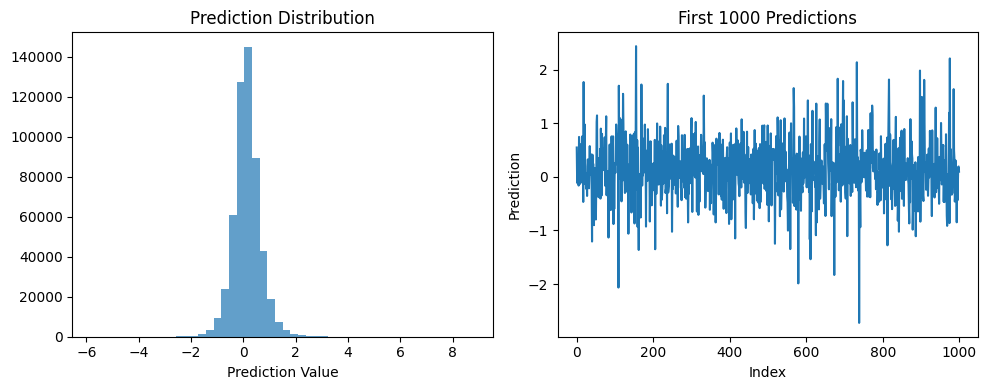

Submission pipeline completed
Upload file: /content/drive/MyDrive/DRW Crypto Market Prediction/final_submission.csv


NameError: name 'X_test' is not defined

In [15]:
# CELL 9: Final Check (Optional)
# Quick distribution plot
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.hist(predictions, bins=50, alpha=0.7)
plt.title('Prediction Distribution')
plt.xlabel('Prediction Value')

plt.subplot(1, 2, 2)
plt.plot(predictions[:1000])
plt.title('First 1000 Predictions')
plt.xlabel('Index')
plt.ylabel('Prediction')

plt.tight_layout()
plt.show()

print("Submission pipeline completed")
print(f"Upload file: {SUBMISSION_PATH}")

# Cleanup
del X_test, final_model
gc.collect()